In [1]:
import copy
import sys
sys.path.insert(0, "..")
import numpy as np
import matplotlib.pyplot as plt
from classes.calculators.lennardjones import LennardJones
from classes.regression.regressers import pol_kernel_func, RBF_kernel_func, pol_kernel_regressor

In [2]:
def dot_prod(x1, x2):
    x1 = np.array([1.0, np.sqrt(2)*x1, x1**2])
    x_dat = np.zeros(shape=(len(x2), 3))
    x_dat[:,0]+=1.0
    x_dat[:,1]+=np.sqrt(2)*x2
    x_dat[:,2]+=x2*x2
    return np.dot(x1, x_dat.T)


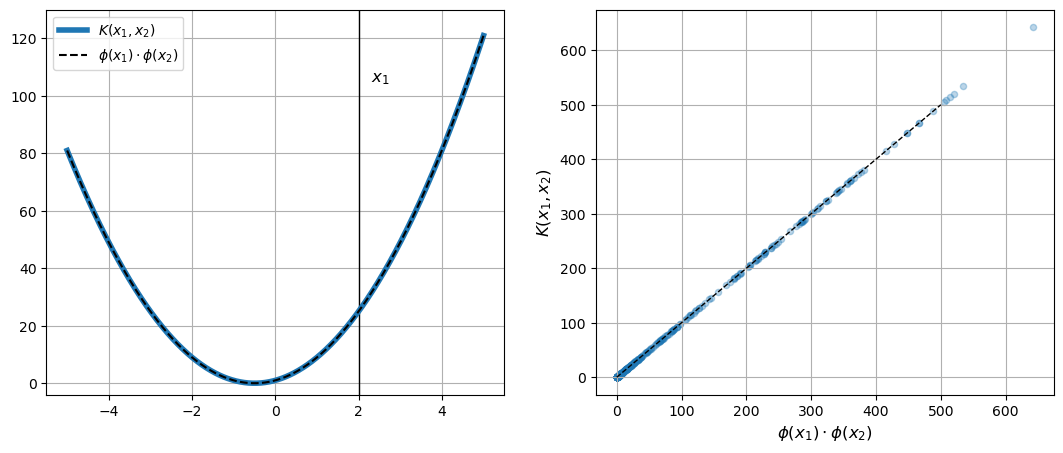

In [3]:
xs = np.linspace(-5.0, 5.0, 1000)
fig, axs = plt.subplots(1,2, figsize=(13,5))
ys_dot = dot_prod(2.0, xs)
ys_kern = pol_kernel_func(x_basis=np.array([2.0]), x_data=xs, N_deg=2).reshape(1,-1)[0]

axs[0].vlines(2, -5,150, lw=1, colors="k")
axs[0].set_ylim([-4, 130])
labels = [r"$\phi(x_1)\cdot\phi(x_2)$", r"$K(x_1,x_2)$"]

axs[0].plot(xs, ys_kern, label=labels[1], lw=4)
axs[0].plot(xs, ys_dot, "--", label=labels[0], c="k")
axs[0].annotate(r"$x_1$",(2.3,105), fontsize=12)
xs1 = np.random.rand(20)*10 - 5.0
xs2 = np.random.rand(20)*10 - 5.0
ys_dot_tot = []
ys_kern_tot = []
for x1 in xs1:
    ys_dot = dot_prod(x1=x1, x2=xs2)
    ys_kern = pol_kernel_func(x_basis=np.array([x1]), x_data=xs2, N_deg=2).reshape(1,-1)[0]
    ys_dot_tot.append(ys_dot)
    ys_kern_tot.append(ys_kern)

axs[1].scatter(np.array(ys_dot_tot).flatten(), np.array(ys_kern_tot).flatten(), alpha=0.3, s=20)
xs = np.linspace(0.0, 500, 100)
axs[1].plot(xs,xs, "--", c="k", lw=1)
axs[1].set_xlabel(labels[0], fontsize=12)
axs[1].set_ylabel(labels[1], fontsize=12)
axs[0].legend()

for ax in axs:
    ax.grid()

In [4]:
class DiscreteRBF():
    def __init__(self, delta_x, sigma=1.0, color="C4") -> None:
        self.delta_x = delta_x
        self.color = color
        self.sigma = sigma
        self.sig_phi = self.sigma/np.sqrt(2.0)
        self.A = np.sqrt(np.sqrt(2.0*np.pi)*self.sigma)
        self.bin_edges = np.arange(-12,12.01, self.delta_x)
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) /2

    def RBF(self, xs, x_val):
        t1 = 1.0/(np.sqrt(2.0*np.pi)*self.sig_phi)
        t2 = np.exp(-(xs-x_val)**2/(2.0*self.sig_phi**2))
        return self.A*t1*t2*np.sqrt(self.delta_x)

    def get_descriptor(self, x_val, return_bins=False):
        return self.RBF(xs=self.bin_centers, x_val=x_val)
    
    def plot(self, x_val, ax):
        desc_vect =self.get_descriptor(x_val, return_bins=True)
        ax.bar(self.bin_centers,desc_vect,width=0.8*self.delta_x,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))


In [5]:
x1 = 0.25
x2 = 0.5
for dx in [0.1,0.02,0.02, 0.04, 0.008, 0.0016, 0.00032, 0.000064]:
    discrete_rbf = DiscreteRBF(delta_x=dx, sigma=0.1)
    desc = discrete_rbf.get_descriptor(x1)
    #print(desc.round(3))
    print(discrete_rbf.get_descriptor(x1) @ discrete_rbf.get_descriptor(x1),
          discrete_rbf.get_descriptor(x2) @ discrete_rbf.get_descriptor(x2),
          discrete_rbf.get_descriptor(x1) @ discrete_rbf.get_descriptor(x2))

1.0143837720622322 0.9856162386389274 0.04393693338831794
1.0000000000000215 1.0000000000000213 0.043936933623408364
1.0000000000000215 1.0000000000000213 0.043936933623408364
1.0000000000000218 1.0000000000001021 0.043936933623410876
1.0000000000001101 1.0000000000001106 0.043936933623412264
1.0000000000001104 1.0000000000001104 0.043936933623412264
0.999999999999 0.9999999999990001 0.04393693362336349
0.9999999999990001 0.9999999999990001 0.04393693362336349


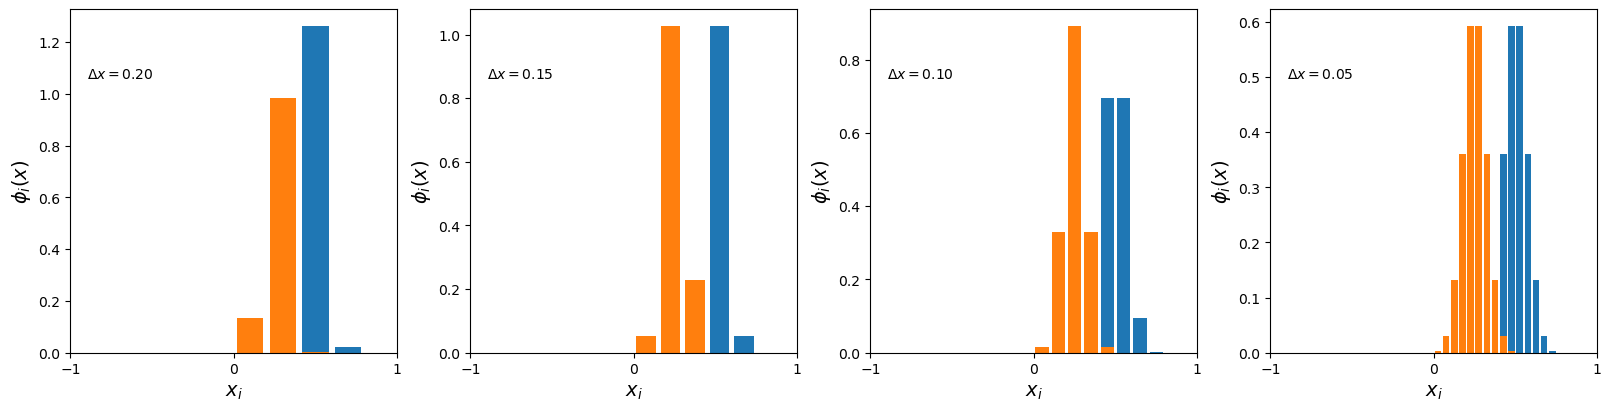

In [6]:
fig, axes = plt.subplots(1,4,figsize=(16,4), layout="constrained")
for ax, dx in zip(axes,[0.2,0.15,0.1,0.05]):
    discrete_rbf = DiscreteRBF(delta_x=dx, sigma=1e-1, color="C0")
    discrete_rbf.plot(0.5,ax)
    discrete_rbf.color="C1"
    discrete_rbf.plot(0.25,ax)
    ax.set_xlabel(r"$x_i$", fontsize=14)
    ax.set_ylabel(r"$\phi_i(x)$", fontsize=14)
    ax.set_xlim([-1,1])
    ax.text(0.05,0.8,f'$\Delta x={dx:.2f}$',transform = ax.transAxes)

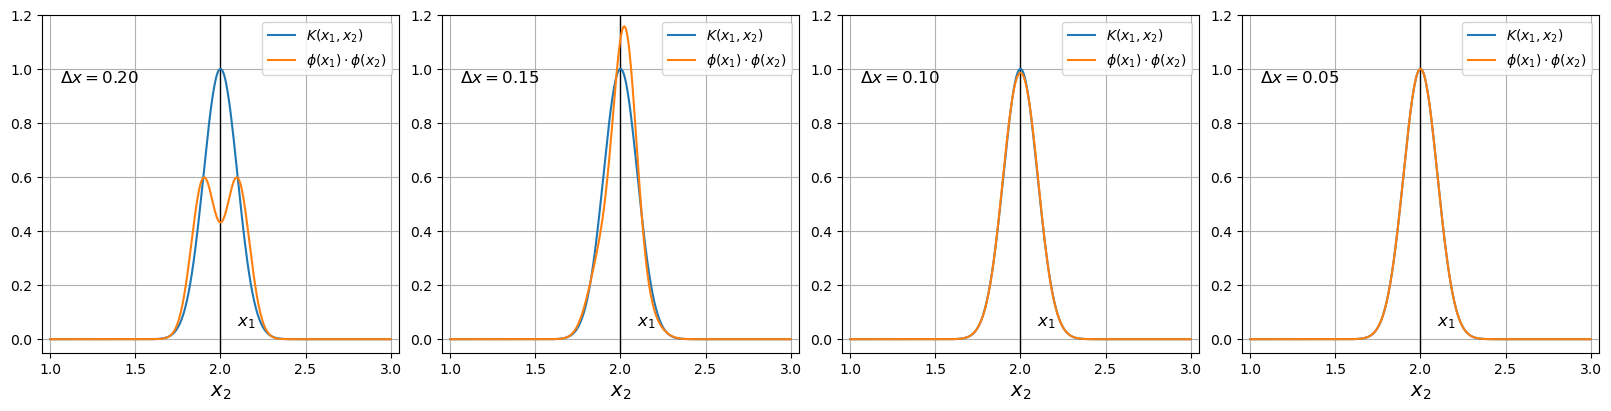

In [47]:
fig, axs = plt.subplots(1,4,figsize=(16,4), layout="constrained")

def K(x1, x2, sigma=1e-1):
    return np.exp(-(x1-x2)**2/(2.0*sigma**2))

xs = np.linspace(1.0, 3.0, 400)

for ax, dx in zip(axs,[0.2,0.15,0.1,0.05]):
    discrete_rbf = DiscreteRBF(delta_x=dx, sigma=1e-1, color="C1")
    phi1 = discrete_rbf.get_descriptor(2.0)
    phi_prod = np.zeros(len(xs))
    for i, x in enumerate(xs):
        phix = discrete_rbf.get_descriptor(x)
        phi_prod[i] = phi1 @ phix
    ax.set_xlabel(r"$x_2$", fontsize=14)
    ax.set_xlim([0.95, 3.05])
    ax.set_ylim([-0.05, 1.2])
    ax.grid()
    ax.vlines(2, -5,150, lw=1, colors="k")
    ax.annotate(r"$x_1$",(2.1,0.05), fontsize=12)
    k = K(xs, 2.0)
    ax.plot(xs, k, label=labels[1])
    ax.plot(xs, phi_prod, label=labels[0])
    ax.legend()
    ax.text(0.05,0.8,f'$\Delta x={dx:.2f}$',transform = ax.transAxes, fontsize=12)




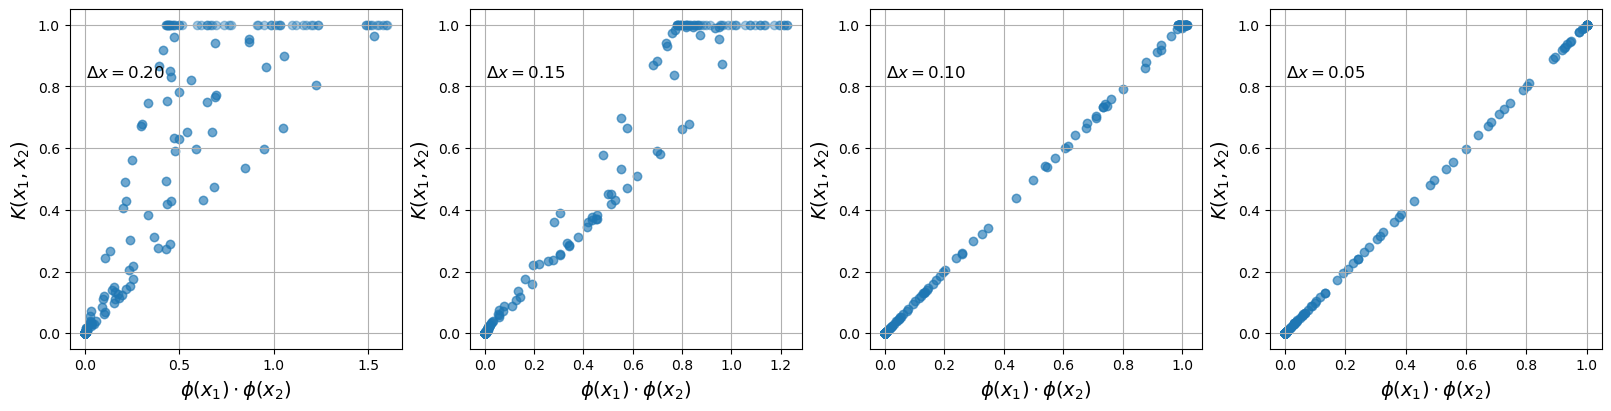

In [48]:
fig, axs = plt.subplots(1,4,figsize=(16,4), layout="constrained")

for ax, dx in zip(axs,[0.2,0.15,0.1,0.05]):
    discrete_rbf = DiscreteRBF(delta_x=dx, sigma=1e-1, color="C1")
    random_points = np.random.rand(50)*10 - 5
    phis = np.zeros(len(random_points)**2)
    ks = np.zeros(len(random_points)**2)
    i = 0
    for x1 in random_points:
        for x2 in random_points:
            phi1 = discrete_rbf.get_descriptor(x1)
            phi2 = discrete_rbf.get_descriptor(x2)
            phis[i] = phi1@phi2
            ks[i] = K(x1,x2)
            i+=1
    ax.grid()
    ax.set_xlabel(labels[0], fontsize=14)
    ax.set_ylabel(labels[1], fontsize=14)
    ax.scatter(phis, ks, alpha=0.4)
    ax.text(0.05,0.8,f'$\Delta x={dx:.2f}$',transform = ax.transAxes, fontsize=12)
